# Deep Learning Term Project for ECG (DIL700)

# Iteration 4

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [3]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df.loc[train_df[187] == 4, 187] = 3
test_df.loc[test_df[187] == 4, 187] = 3
full_df.loc[full_df[187] == 4, 187] = 3


In [4]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [5]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [6]:
print(train_df[187].unique())

[0. 1. 2. 3.]


In [7]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["N","S","V","Q"]

In [8]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))

Number of samples in data:
Normal : 72471
Artial Premature : 2223
Premature ventricular contraction : 5788
Paced : 6431


In [9]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))

Number of samples in data:
Normal : 18118
Artial Premature : 556
Premature ventricular contraction : 1448
Paced : 1608


## Preparation

In [10]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

In [11]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
28367,0.989610,0.888312,0.425974,0.049351,0.096104,0.124675,0.101299,0.093506,0.096104,0.090909,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62622,1.000000,0.954751,0.266968,0.000000,0.063348,0.099548,0.104072,0.176471,0.153846,0.126697,...,0.298643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3227,1.000000,0.942431,0.686567,0.422175,0.321962,0.268657,0.179104,0.138593,0.149254,0.147122,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57171,1.000000,0.875831,0.170732,0.000000,0.106430,0.137472,0.128603,0.119734,0.113082,0.099778,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69122,1.000000,0.773333,0.053333,0.073333,0.090000,0.093333,0.086667,0.093333,0.083333,0.086667,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38510,0.975357,0.941634,0.498054,0.000000,0.068742,0.125811,0.057069,0.050584,0.044099,0.040208,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19805,0.990672,0.777985,0.139925,0.037313,0.098881,0.102612,0.115672,0.111940,0.110075,0.123134,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41091,1.000000,0.905405,0.705405,0.354054,0.170270,0.124324,0.102703,0.059459,0.062162,0.037838,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4546,1.000000,0.510791,0.000000,0.089928,0.089928,0.118705,0.111511,0.115108,0.097122,0.107914,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
y_train

28367    0.0
62622    0.0
3227     0.0
57171    0.0
69122    0.0
        ... 
38510    0.0
19805    0.0
41091    0.0
4546     0.0
77955    2.0
Name: 187, Length: 69530, dtype: float64

In [13]:
y_train_nn

,N,S,V,Q
28367,1,0,0,0
62622,1,0,0,0
3227,1,0,0,0
57171,1,0,0,0
69122,1,0,0,0
...,...,...,...,...
38510,1,0,0,0
19805,1,0,0,0
41091,1,0,0,0
4546,1,0,0,0


In [14]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
14772,0.964912,0.912281,0.583960,0.273183,0.147870,0.120301,0.092732,0.060150,0.050125,0.030075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49137,0.987080,0.953488,0.731266,0.253230,0.069767,0.139535,0.103359,0.038760,0.012920,0.025840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31361,0.000000,0.294118,0.745098,0.281046,0.117647,0.372549,0.588235,0.575163,0.633987,0.620915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60850,0.817021,0.646809,0.178723,0.051064,0.085106,0.136170,0.131915,0.229787,0.234043,0.136170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64495,1.000000,0.890966,0.520249,0.261682,0.168224,0.161994,0.118380,0.099688,0.074766,0.087227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45252,0.993661,0.801902,0.193344,0.000000,0.215531,0.213946,0.221870,0.231379,0.231379,0.225040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61241,1.000000,0.789256,0.107438,0.012397,0.097107,0.088843,0.070248,0.057851,0.047521,0.051653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30540,1.000000,0.695946,0.087838,0.020270,0.077703,0.094595,0.097973,0.091216,0.091216,0.087838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86618,1.000000,0.854054,0.578378,0.370270,0.275676,0.300000,0.291892,0.308108,0.297297,0.305405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Distribution

### Training set

In [15]:
train_df[187]=train_df[187].astype(int)
equilibre_train=train_df[187].value_counts(sort=False)
print(equilibre_train)

0    72471
1     2223
2     5788
3     6431
Name: 187, dtype: int64


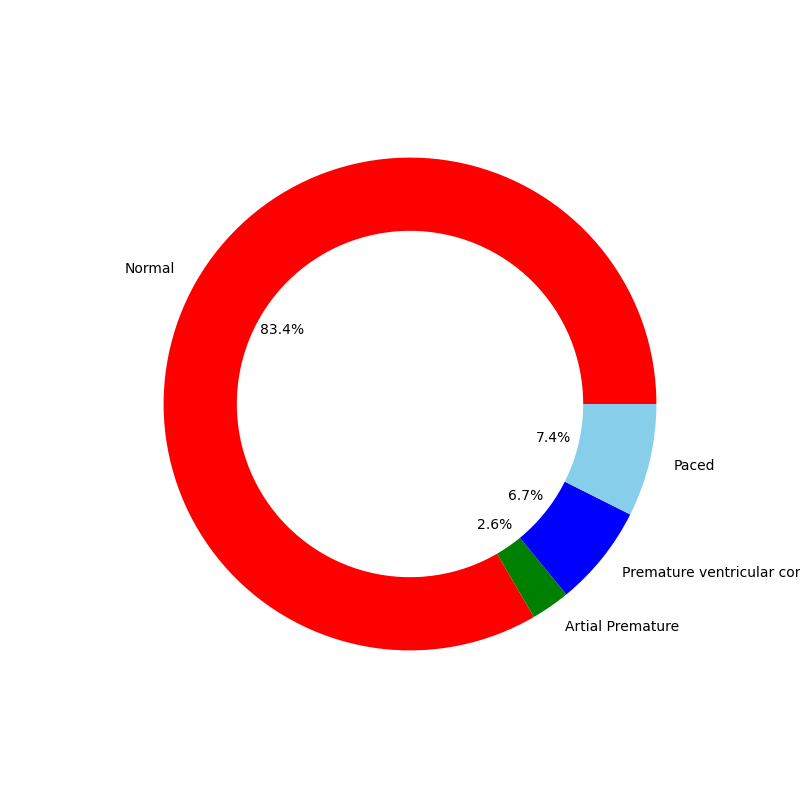

In [16]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [17]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    18118
1      556
2     1448
3     1608
Name: 187, dtype: int64


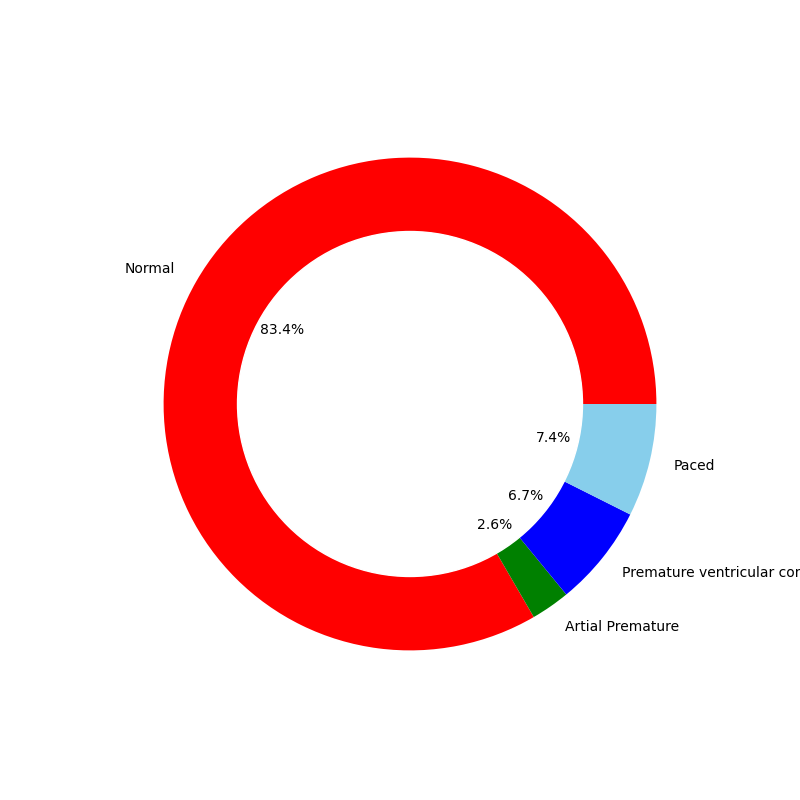

In [18]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Hyperparameter optimization ANN

Info about the algo: https://www.blopig.com/blog/wp-content/uploads/2019/10/GPyOpt-Tutorial1.html

In [19]:
import GPyOpt

timestamp = datetime.datetime.now().strftime("%d%m%Y_%H%M%S")
report_file = 'gpyopt_ann_4' + '_' + timestamp + '.txt'
f = open(report_file, "x")
f.close()

cell_outputs = []

# define the search space for the Bayesian optimization
space = [{'name': 'num_layers', 'type': 'discrete', 'domain': (5, 6, 7, 8, 9, 10, 11)},
         {'name': 'num_neurons', 'type': 'discrete', 'domain': (8, 16, 32)},
         {'name': 'activation', 'type': 'discrete', 'domain': (0, 1, 2, 3)}]
max_iter = 500
epochs = 40

# testing only, remove later
if False:
    space = [{'name': 'num_layers', 'type': 'discrete', 'domain': (1, 2)},
            {'name': 'num_neurons', 'type': 'discrete', 'domain': (4, 5)},
            {'name': 'activation', 'type': 'discrete', 'domain': (1, 2)}]
    max_iter = 5
    epochs = 2

# define the objective function to be optimized
def objective_function(x):

    num_layers = int(x[:, 0])
    num_neurons = int(x[:, 1])
    activations = ['sigmoid', 'tanh', 'relu', 'selu']
    activation_func = activations[int(x[:, 2])]

    # create the model from the custom function
    model = ann_network(num_layers, num_neurons, activation_func, 4, X_train)

    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    # docs
    cell_outputs.append(f'Fitting model: {num_layers} layers, {num_neurons} neurons, {activation_func} \t\t')
    print(f'Fitting model: {num_layers} layers, {num_neurons} neurons, {activation_func}', end='\t\t')

    # train the model and return the validation accuracy
    history = model.fit(X_train, y_train_nn, validation_data=(X_valid, y_valid_nn), callbacks=callbacks, batch_size=16, epochs=epochs, verbose=0)
    val_acc = max(history.history['val_accuracy'])

    # docs
    cell_outputs.append(f'Best validation accuracy: {val_acc*100:.2f} %')
    cell_outputs.append('\n')
    print(f'Best validation accuracy: {val_acc*100:.2f} %')
    print()

    return -val_acc  # negative because GPyOpt minimizes the objective function

# specify the initial design points for Bayesian optimization
# design = np.array([[4, 16, 'relu'], [4, 32, 'sigmoid'], [5, 32, 'tanh']])

# create a GPyOpt object and run Bayesian optimization
# create a GPyOpt object and run Bayesian optimization
bo = GPyOpt.methods.BayesianOptimization(f=objective_function, 
                                         domain=space, 
                                         verbosity=True, 
                                         verbosity_model=True,
                                         exact_feval=True,
                                         initial_design_numdata=50)
                                         
bo.run_optimization(max_iter=max_iter, report_file=report_file)

# print the optimal architecture and validation accuracy
opt_num_layers = int(bo.x_opt[0])
opt_num_neurons = int(bo.x_opt[1])
activations = ['sigmoid', 'tanh', 'relu', 'selu']
best_activation = activations[int(bo.x_opt[2])]
opt_val_acc = -bo.fx_opt
print(f"Optimal architecture: {opt_num_layers} layers, {opt_num_neurons} neurons per layer, {best_activation} activation function")
print(f"Optimal validation accuracy: {opt_val_acc:.5f}")

# save results to text file
with open(report_file, 'a') as file1:
    file1.write("\n---------- Cell outputs ----------\n")
    for i in range(len(cell_outputs)):
        file1.write(cell_outputs[i])
    file1.write('\n')
    file1.write(f"Optimal architecture: {opt_num_layers} layers, {opt_num_neurons} neurons per layer, {best_activation} activation function")
    file1.write('\n')
    file1.write(f"Optimal validation accuracy: {opt_val_acc:.5f}")


Fitting model: 11 layers, 32 neurons, tanh		Best validation accuracy: 83.24 %

Fitting model: 6 layers, 16 neurons, sigmoid		Best validation accuracy: 98.30 %

Fitting model: 5 layers, 32 neurons, selu		Best validation accuracy: 98.11 %

Fitting model: 8 layers, 32 neurons, sigmoid		Best validation accuracy: 83.24 %

Fitting model: 11 layers, 32 neurons, tanh		Best validation accuracy: 83.24 %

Fitting model: 9 layers, 32 neurons, selu		Best validation accuracy: 97.66 %

Fitting model: 10 layers, 16 neurons, relu		Best validation accuracy: 98.25 %

Fitting model: 8 layers, 32 neurons, relu		Best validation accuracy: 98.17 %

Fitting model: 8 layers, 16 neurons, tanh		Best validation accuracy: 97.58 %

Fitting model: 11 layers, 32 neurons, relu		Best validation accuracy: 97.72 %

Fitting model: 9 layers, 32 neurons, tanh		Best validation accuracy: 83.24 %

Fitting model: 7 layers, 32 neurons, selu		Best validation accuracy: 98.06 %

Fitting model: 6 layers, 8 neurons, tanh		Best validat

In [20]:
cell_outputs

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


['Fitting model: 11 layers, 32 neurons, tanh \t\t',
 'Best validation accuracy: 83.24 %',
 '\n',
 'Fitting model: 6 layers, 16 neurons, sigmoid \t\t',
 'Best validation accuracy: 98.30 %',
 '\n',
 'Fitting model: 5 layers, 32 neurons, selu \t\t',
 'Best validation accuracy: 98.11 %',
 '\n',
 'Fitting model: 8 layers, 32 neurons, sigmoid \t\t',
 'Best validation accuracy: 83.24 %',
 '\n',
 'Fitting model: 11 layers, 32 neurons, tanh \t\t',
 'Best validation accuracy: 83.24 %',
 '\n',
 'Fitting model: 9 layers, 32 neurons, selu \t\t',
 'Best validation accuracy: 97.66 %',
 '\n',
 'Fitting model: 10 layers, 16 neurons, relu \t\t',
 'Best validation accuracy: 98.25 %',
 '\n',
 'Fitting model: 8 layers, 32 neurons, relu \t\t',
 'Best validation accuracy: 98.17 %',
 '\n',
 'Fitting model: 8 layers, 16 neurons, tanh \t\t',
 'Best validation accuracy: 97.58 %',
 '\n',
 'Fitting model: 11 layers, 32 neurons, relu \t\t',
 'Best validation accuracy: 97.72 %',
 '\n',
 'Fitting model: 9 layers, 32 

In [21]:
best_ann = ann_network(num_layers=opt_num_layers, num_neurons_last_hidden=opt_num_neurons, activation_function=best_activation, num_classes=4, X_train=X_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
            ModelCheckpoint(filepath='best_ann_5_opt.h5', monitor='val_loss', save_best_only=True)]

# train the model
history_ann_opt = best_ann.fit(X_train, y_train_nn, validation_data=(X_valid, y_valid_nn), callbacks=callbacks, batch_size=32, epochs=40, verbose=1)

best_ann.load_weights('best_ann_5_opt.h5')
save_model(best_ann, 'Optimized_ANN_MITBIH', 'keras')


Epoch 1/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.5140 - accuracy: 0.8589 - val_loss: 0.3437 - val_accuracy: 0.9056
Epoch 2/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.3055 - accuracy: 0.9213 - val_loss: 0.2785 - val_accuracy: 0.9304
Epoch 3/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.2414 - accuracy: 0.9387 - val_loss: 0.2201 - val_accuracy: 0.9425
Epoch 4/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.2060 - accuracy: 0.9458 - val_loss: 0.1951 - val_accuracy: 0.9501
Epoch 5/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.1789 - accuracy: 0.9563 - val_loss: 0.1669 - val_accuracy: 0.9582
Epoch 6/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.1597 - accuracy: 0.9607 - val_loss: 0.1595 - val_accuracy: 0.9589
Epoch 7/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.1452 - accuracy: 0.9630 - val_loss: 0.1490 - val_accuracy:

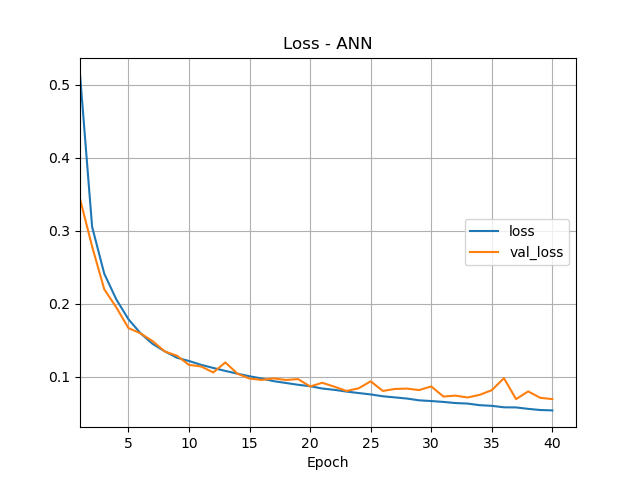

In [22]:
history_df_ann = pd.DataFrame(history_ann_opt.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

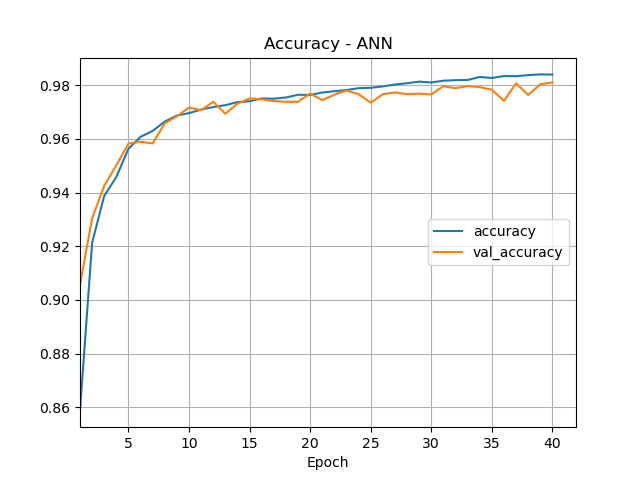

In [23]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [24]:
# Predict test set labels
y_pred_ann_proba = best_ann.predict(X_test, verbose=0)
y_pred_ann = np.argmax(y_pred_ann_proba , axis=1)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred_ann):.5f}')

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


Accuracy: 0.97966


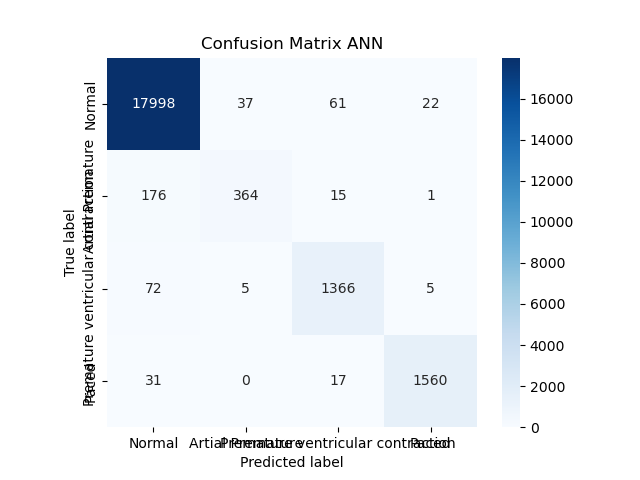

In [25]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure()
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix ANN')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [26]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

                                   precision    recall  f1-score   support

                           Normal     0.9847    0.9934    0.9890     18118
                 Artial Premature     0.8966    0.6547    0.7568       556
Premature ventricular contraction     0.9363    0.9434    0.9398      1448
                            Paced     0.9824    0.9701    0.9762      1608

                         accuracy                         0.9797     21730
                        macro avg     0.9500    0.8904    0.9155     21730
                     weighted avg     0.9791    0.9797    0.9789     21730



# Hyperparameter optimization CNN

In [27]:
import GPyOpt

timestamp = datetime.datetime.now().strftime("%d%m%Y_%H%M%S")
report_file = 'gpyopt_cnn_4' + '_' + timestamp + '.txt'
f = open(report_file, "x")
f.close()

cell_outputs = []

# define the search space for the Bayesian optimization
space = [
    {'name': 'num_conv_blocks', 'type': 'discrete', 'domain': (1, 2, 3, 4, 5, 6)},
    {'name': 'strides', 'type': 'discrete', 'domain': (1, 2)},
    {'name': 'num_dense_layers', 'type': 'discrete', 'domain': (1, 2, 3, 4)},
    {'name': 'num_neurons_last_hidden', 'type': 'discrete', 'domain': (8, 16, 32, 64)},
]
max_iter = 500
epochs = 40

# testing only, remove later
if False:
    space = [
        {'name': 'num_conv_blocks', 'type': 'discrete', 'domain': (1, 2)},
        {'name': 'strides', 'type': 'discrete', 'domain': (1, 2)},
        {'name': 'num_dense_layers', 'type': 'discrete', 'domain': (1, 2)},
        {'name': 'num_neurons_last_hidden', 'type': 'discrete', 'domain': (4, 8)},
    ]
    max_iter = 3
    epochs = 1


# define the objective function to be optimized
def objective_function(x):

    num_conv_blocks = int(x[:, 0])
    strides = int(x[:, 1])
    num_dense_layers = int(x[:, 2])
    num_neurons_last_hidden = int(x[:, 3])

    # create the model from the custom function
    model = cnn_network(num_conv_blocks, strides, num_dense_layers, num_neurons_last_hidden, 4, X_train)

    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    # docs
    cell_outputs.append(f'Fitting model: {num_conv_blocks} conv blocks, {strides} striding for pool, {num_dense_layers} dense layers, {num_neurons_last_hidden} neurons on last dense layer \t\t')
    print(f'Fitting model: {num_conv_blocks} conv blocks, {strides} striding for pool, {num_dense_layers} dense layers, {num_neurons_last_hidden} neurons on last dense layer', end='\t\t')

    # train the model and return the validation accuracy
    history = model.fit(X_train, y_train_nn, validation_data=(X_valid, y_valid_nn), callbacks=callbacks, batch_size=16, epochs=epochs, verbose=0)
    val_acc = max(history.history['val_accuracy'])

    # docs
    cell_outputs.append(f'Best validation accuracy: {val_acc*100:.2f} %')
    cell_outputs.append('\n')
    print(f'Best validation accuracy: {val_acc*100:.2f} %')
    print()

    return -val_acc  # negative because GPyOpt minimizes the objective function

# create a GPyOpt object and run Bayesian optimization
bo = GPyOpt.methods.BayesianOptimization(f=objective_function, 
                                         domain=space, 
                                         verbosity=True, 
                                         verbosity_model=True,
                                         exact_feval=True,
                                         initial_design_numdata=50)

bo.run_optimization(max_iter=max_iter, report_file=report_file)

# print the optimal architecture and validation accuracy
opt_num_convblocks = int(bo.x_opt[0])
opt_num_strides = int(bo.x_opt[1])
opt_num_dense_layers = int(bo.x_opt[2])
opt_num_neurons_last_hidden = int(bo.x_opt[3])
opt_val_acc = -bo.fx_opt
print(f"Optimal architecture: {opt_num_convblocks} conv blocks, {opt_num_strides} striding for pool, {opt_num_dense_layers} dense layers, {opt_num_neurons_last_hidden} neurons on last dense layer")
print(f"Optimal validation accuracy: {opt_val_acc:.5f}")

# save results to text file
with open(report_file, 'a') as file1:
    file1.write("\n---------- Cell outputs ----------\n")
    for i in range(len(cell_outputs)):
        file1.write(cell_outputs[i])
    file1.write('\n')
    file1.write(f"Optimal architecture: {opt_num_convblocks} conv blocks, {opt_num_strides} striding for pool, {opt_num_dense_layers} dense layers, {opt_num_neurons_last_hidden} neurons on last dense layer")
    file1.write('\n')
    file1.write(f"Optimal validation accuracy: {opt_val_acc:.5f}")


Fitting model: 5 conv blocks, 2 striding for pool, 4 dense layers, 16 neurons on last dense layer		Best validation accuracy: 99.07 %

Fitting model: 6 conv blocks, 1 striding for pool, 4 dense layers, 32 neurons on last dense layer		Best validation accuracy: 98.84 %

Fitting model: 5 conv blocks, 1 striding for pool, 3 dense layers, 16 neurons on last dense layer		Best validation accuracy: 98.92 %

Fitting model: 5 conv blocks, 1 striding for pool, 2 dense layers, 32 neurons on last dense layer		Best validation accuracy: 98.86 %

Fitting model: 4 conv blocks, 1 striding for pool, 1 dense layers, 64 neurons on last dense layer		Best validation accuracy: 98.48 %

Fitting model: 4 conv blocks, 2 striding for pool, 3 dense layers, 32 neurons on last dense layer		Best validation accuracy: 98.99 %

Fitting model: 1 conv blocks, 1 striding for pool, 1 dense layers, 64 neurons on last dense layer		Best validation accuracy: 97.97 %

Fitting model: 6 conv blocks, 2 striding for pool, 1 dense lay

In [ ]:
best_cnn = cnn_network(num_conv_blocks=opt_num_convblocks, strides=opt_num_strides, num_dense_layers=opt_num_dense_layers, num_neurons_last_hidden=opt_num_neurons_last_hidden, num_classes=4, X_train=X_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
            ModelCheckpoint(filepath='best_cnn_4_opt.h5', monitor='val_loss', save_best_only=True)]

# train the model
history_cnn_opt = best_cnn.fit(X_train, y_train_nn, validation_data=(X_valid, y_valid_nn), callbacks=callbacks, batch_size=32, epochs=40, verbose=1)

best_cnn.load_weights('best_cnn_4_opt.h5')
save_model(best_cnn, 'Optimized_CNN_MITBIH', 'keras')


In [ ]:
history_df_cnn = pd.DataFrame(history_cnn_opt.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
# Predict test set labels
y_pred_cnn_proba = best_cnn.predict(X_test, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn_proba , axis=1)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred_cnn):.5f}')

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure()
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix CNN')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_cnn, target_names=labels, digits=4))